In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os

In [3]:
#CONSTANTS - working with files
ROOT_DIRECTORY = os.path.join("drive", "My Drive", "Colab Notebooks", "working")
import sys
sys.path.append(ROOT_DIRECTORY)

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
import os

from utils.files import *
from utils.visualize import *
from utils.BoundingBox import *

In [6]:
#reproducability!
random_seed = 27
import random
random.seed(random_seed)
np.random.seed(random_seed)

# Exploratory Data Analysis 

First, we try to investigate the data and to extract the information that we could use in the further processing. 
There are three basic types of cells - RBC - red blood cells (erythrocytes), WBC - white blood cells (leukocytes) and platelets (thrombocytes).

Also, there are white blood cells subtypes:
 - Mononuclear 
    - Basophil 
    - Lymphocyte
    - Monocyte
 - Polynuclear 
    - Neutrophil 
    - Eosinophil

## Loading datasets

Actually, we have four different datasets.

Remark:
We have a separate module ./utils/files.py for reading text files and images

In [7]:
# files and folders constants
#-----------------------------------------------------------
datasets_dir = os.path.join(f"{ROOT_DIRECTORY}", "datasets")
ds1_dir = os.path.join(datasets_dir, "Dataset1")
ds1_images_dir = os.path.join(ds1_dir, "images")
ds1_annotations_dir = os.path.join(ds1_dir, "annotations")
ds1_labels_filepath = os.path.join(ds1_dir, "labels.csv")
masks_dir = os.path.join(ds1_dir, "masks")
make_dir(masks_dir)

ds2_dir = os.path.join(datasets_dir, "Dataset2")
ds2_1_images_dir = os.path.join(ds2_dir, "Dataset 1")
ds2_2_images_dir = os.path.join(ds2_dir, "Dataset 2")
ds2_1_labels_filepath = os.path.join(ds2_dir, "Class Labels of Dataset 1.csv")
ds2_2_labels_filepath = os.path.join(ds2_dir, "Class Labels of Dataset 2.csv")

ds3_dir = os.path.join(datasets_dir, "Dataset3")
ds3_images_dir = os.path.join(ds3_dir, "images")
ds3_masks_dir = os.path.join(ds3_dir, "Ground Truth Segmentation")
ds3_masks_subdirname = "areaforexpert1"
#-----------------------------------------------------------


Directory '/content/drive/My Drive/Colab Notebooks/working/datasets/Dataset1/masks' already exists!


We will try to create a combine dataset - dataframe with the columns defined below.
Remarks:
- When we do not have annotations for the bounding boxes, we create such using the given masks.
- When we do not have a mask, we create one using the bounding boxes and a circle inscribed in the rectangle (Although it is not a great way for creating a correct mask but the image processing trials for segmented a more correct mask on the given data does not provide better results...)

In [8]:
dataset_columns = ["image_filepath",
                    "mask_filepath",
                    "dataset", 
                    "label", 
                    "xmin", 
                    "ymin", 
                    "xmax",
                    "ymax"]

### Dataset 1 
Source: BCCD (Shenggan) https://mahmudulalam.github.io/Complete-Blood-Cell-Count-Dataset/  (https://paperswithcode.com/dataset/bccd)

The dataset consists of:
 - (640 x 480) JPEG images (364 valid ones)
 -  annotations in PASCAL VOC format depicting the coordinates of the enclosing rectangle around each cell
 - labels.csv with white cells subtypes

 Remark:
 - We have a separate module ./utils/BoundingBox.py to extract the bounding boxes from the PASCAL VOC annotations XML

Let's look a sample image from the dataset 1:

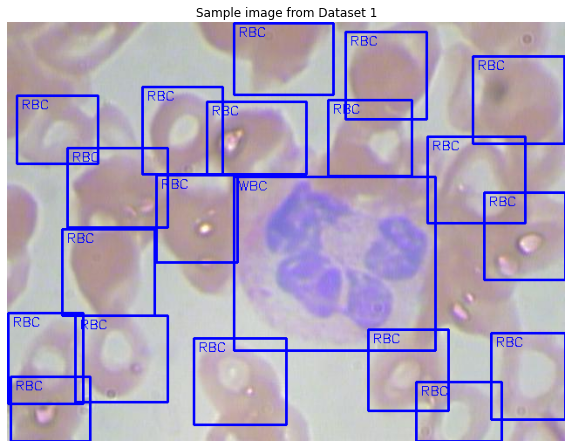

In [9]:
ds1_sample_imagename = "BloodImage_00000"
ds1_sample_image = read_image(os.path.join(ds1_images_dir, f"{ds1_sample_imagename}.jpg"))
ds1_sample_annotation = read_text(os.path.join(ds1_annotations_dir, f"{ds1_sample_imagename}.xml"))
ds1_bounding_boxes = find_bounding_boxes(ds1_sample_annotation)
show_image_with_bounding_boxes(ds1_sample_image, "Sample image from Dataset 1", ds1_bounding_boxes)

Here is the content of the CSV file with labeled white cells:

In [10]:
ds1_labels_csv = pd.read_csv(ds1_labels_filepath, usecols=range(2, 3)).Category
print(ds1_labels_csv.sample(10))

91     NEUTROPHIL
21     LYMPHOCYTE
332    NEUTROPHIL
29     NEUTROPHIL
311    NEUTROPHIL
152    EOSINOPHIL
296    NEUTROPHIL
3      NEUTROPHIL
162    EOSINOPHIL
145    NEUTROPHIL
Name: Category, dtype: object


In [11]:
def create_mask_image_for_bounding_boxes(image, file_path, bounding_boxes):
    w, h,_ = image.shape
    clone = np.zeros((w, h))

    i = 1
    for bb in bounding_boxes:
        extracted_clone = clone[bb.ymin:bb.ymax, bb.xmin:bb.xmax]
        
        x_center = (bb.xmin + bb.xmax) / 2
        y_center = (bb.ymin + bb.ymax) / 2
        center = (int(x_center), int(y_center))
        radius = int((bb.xmax - bb.xmin) / 2)
        clone = cv2.circle(clone, center, radius, i, -1)
        i+=1
    
    cv2.imwrite(file_path, clone)

def get_images_data_with_annotations(images_dir, annotations_dir, labels_filepath, masks_dir, database_name):
    data = []

    image_labels = pd.read_csv(labels_filepath, usecols=range(2, 3)).Category
    min_index, max_index = 0, len(image_labels)
    
    for i in range(min_index, max_index):

        image_filename = f"BloodImage_{str(i).zfill(5)}"
        image_filepath = os.path.join(images_dir, f"{image_filename}.jpg")        
        mask_filepath = os.path.join(masks_dir, f"{image_filename}.jpg")

        image = read_image(image_filepath)
        image_ann_file = read_text(os.path.join(annotations_dir, f"{image_filename}.xml"))

        if image.any() and image_ann_file is not None:
            
            bbs = find_bounding_boxes(image_ann_file)

            create_mask_image_for_bounding_boxes(image, mask_filepath, bbs)

            if bbs.any():

                is_wbc = np.array([bb.label == 'WBC' for bb in bbs])
                wbcs = bbs[is_wbc]

                if not(pd.isna(image_labels[i])):
                   
                    wbcs_labels = [l.strip() for l in image_labels[i].split(',')]

                    min_len = min(len(wbcs), len(wbcs_labels))
                    for j in range(0, min_len):
                        bb = wbcs[j]
                        data.append([image_filepath, mask_filepath, database_name, wbcs_labels[j].lower(), bb.xmin, bb.ymin, bb.xmax, bb.ymax])

                elif(len(wbcs) > 0):
                    print(f"Undefined WBC subtypes for image {image_filename}")

                for bb in bbs[~is_wbc]:
                    data.append([image_filepath, mask_filepath, database_name, bb.label.lower(), bb.xmin, bb.ymin, bb.xmax, bb.ymax])

            else:
                print(f"Missing bounding boxes for image {image_filename}")
        #else:
        #    print(f"Missing image or annotation file for {image_filename}")

    images_data = pd.DataFrame(data, columns=dataset_columns)
    return images_data


Now we have the loaded the first dataset:

In [12]:
df1 = get_images_data_with_annotations(ds1_images_dir, ds1_annotations_dir, ds1_labels_filepath, masks_dir, "Dataset1")
df1

Undefined WBC subtypes for image BloodImage_00117


image_filepath  ... ymax
0     drive/My Drive/Colab Notebooks/working/dataset...  ...  376
1     drive/My Drive/Colab Notebooks/working/dataset...  ...  435
2     drive/My Drive/Colab Notebooks/working/dataset...  ...  336
3     drive/My Drive/Colab Notebooks/working/dataset...  ...  461
4     drive/My Drive/Colab Notebooks/working/dataset...  ...  445
...                                                 ...  ...  ...
4881  drive/My Drive/Colab Notebooks/working/dataset...  ...  387
4882  drive/My Drive/Colab Notebooks/working/dataset...  ...  321
4883  drive/My Drive/Colab Notebooks/working/dataset...  ...  320
4884  drive/My Drive/Colab Notebooks/working/dataset...  ...  167
4885  drive/My Drive/Colab Notebooks/working/dataset...  ...  327

[4886 rows x 8 columns]

In [13]:
print("Unique files:", len(np.unique(df1.image_filepath)))

Unique files: 364


('basophil', 3)
('eosinophil', 90)
('lymphocyte', 38)
('monocyte', 22)
('neutrophil', 217)
('platelets', 361)
('rbc', 4155)


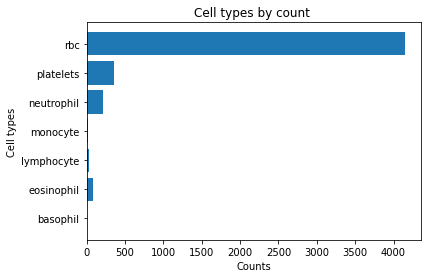

In [14]:
show_barplot_celltypes(df1)

In [15]:
def show_white_celltypes(df):
    ds = df[((df.label != 'rbc') & (df.label != "platelets"))].drop_duplicates("label")
    labels = [l for l in ds.label]
    imgs_with_bbs = \
     [(read_image(row[0]), BoundingBox(row[1], row[2], row[3], row[4], row[5])) for row in ds[["image_filepath", "xmin", "xmax", "ymin", "ymax", "label"]].values]
    imgs = [get_image_with_bounding_boxes(img, [bb]) for (img, bb) in imgs_with_bbs]
    show_images(imgs, labels, "", 30)

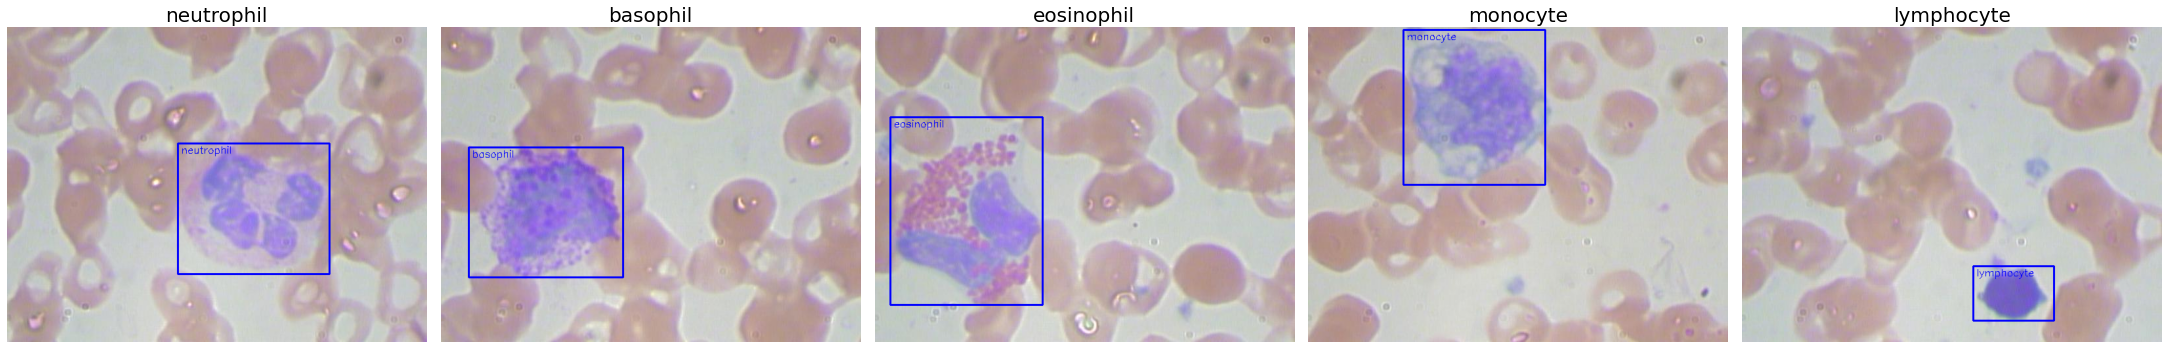

In [16]:
show_white_celltypes(df1)


### Dataset2

Source: WBC (zxaoyou)  (https://github.com/zxaoyou/segmentation_WBC)

The dataset consists of the two subsets with masks only for the white blood cells, the red cells are not segmented.

- Subdataset1:
    - (120 x 120) BMP images (300)
    - (120 x 120) PNG masks with segmented white cell type
    - annotations in a CSV file
- Subdataset2:
    - (300 x 300) BMP images (200)
    - (300 x 300) PNG masks with segmented white cell type
    - annotations in a CSV file 
 
*The labels (1-5) in the annotations csv file represent neutrophil, lymphocyte, monocyte, eosinophil and basophil, respectively.



In [17]:
labels_map = {1: "neutrophil",
          2: "lymphocyte",
          3: "monocyte",
          4: "eosinophil",
          5: "basophil"}

def get_labels_from_csv(labels_filepath, label_column_name):
    image_labels_df = pd.read_csv(labels_filepath)
    image_labels_df[label_column_name] = image_labels_df[label_column_name].apply(lambda x: labels_map[x])
    image_labels = image_labels_df[label_column_name].values
    return image_labels

Currently we process only one mask for an image as there are wrong masks with multiple marked pixels, not only belonging to the mask itself.

In [18]:
def get_bounding_box_from_mask(image, label, mask_filepath):
    
    bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    contours, _  = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bb = None
    if(len(contours) == 1):
        x, y, w, h = cv2.boundingRect(contours[0]) 
        xmin, xmax, ymin, ymax = x, x+w, y, y+h
        bb = BoundingBox(xmin, xmax, ymin, ymax, label)
    else:
        print(f"Not exactly one mask extracted from: '{mask_filepath}'")

    return bb


In [19]:
def show_sample_image_with_bb_from_mask(images_dir, labels_filepath, labels_column_name, dataset_name):
    ind = 9
    imagename = f"{str(ind).zfill(3)}"
    image = read_image(os.path.join(images_dir, f"{imagename}.bmp"))
    mask = read_image(os.path.join(images_dir, f"{imagename}.png"))
    label = get_labels_from_csv(labels_filepath, labels_column_name)[ind]
    bb = get_bounding_box_from_mask(mask, label, imagename)

    show_image_with_bounding_boxes(image, f"Sample image from {dataset_name} ({label})", [bb])

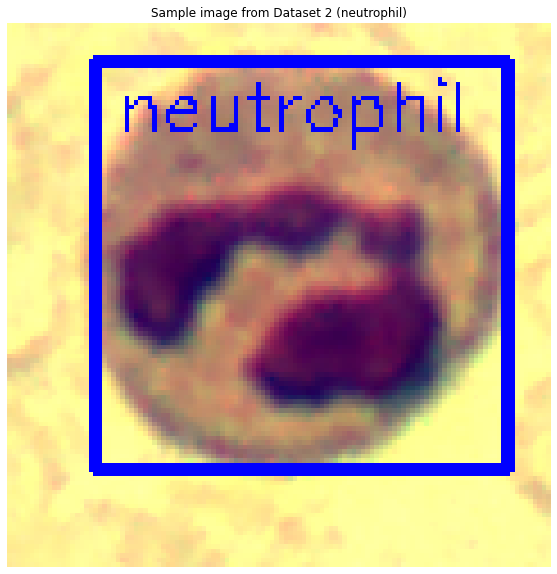

In [20]:
show_sample_image_with_bb_from_mask(ds2_1_images_dir, ds2_1_labels_filepath, "class label", "Dataset 2")

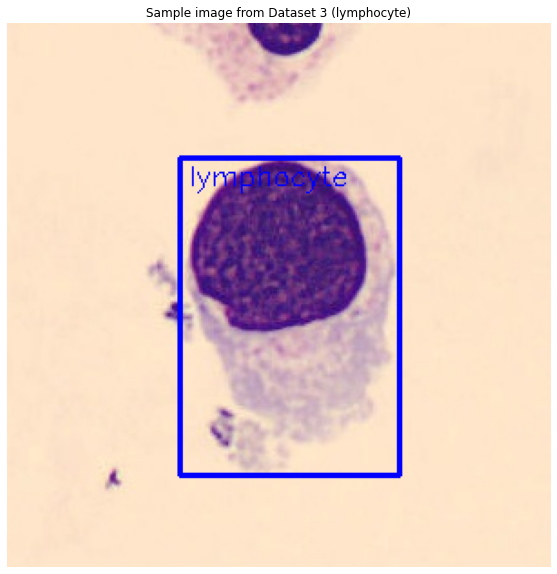

In [21]:
show_sample_image_with_bb_from_mask(ds2_2_images_dir, ds2_2_labels_filepath, "class", "Dataset 3")

In [22]:
def get_images_data_from_masks_in_same_dir(images_dir, labels_filepath, labels_column_name, database_name):
    data = []

    image_labels = get_labels_from_csv(labels_filepath, labels_column_name)

    min_index, max_index = 0, len(image_labels)
    
    for i in range(min_index, max_index):
        image_filename = f"{str(i+1).zfill(3)}"
        image_filepath = os.path.join(images_dir, f"{image_filename}.bmp")
        mask_filepath = os.path.join(images_dir, f"{image_filename}.png")

        image = read_image(image_filepath)
        mask = read_image(mask_filepath)

        if image.any() and mask.any():
            bb = get_bounding_box_from_mask(mask, image_labels[i], mask_filepath)
            if bb is not None:
                data.append([image_filepath, mask_filepath, database_name, image_labels[i], bb.xmin, bb.ymin, bb.xmax, bb.ymax])
        i+=1

    images_data = pd.DataFrame(data, columns=dataset_columns)
    return images_data


In [23]:
df2 = get_images_data_from_masks_in_same_dir(ds2_1_images_dir, ds2_1_labels_filepath, "class label", "Dataset2")
df2

image_filepath  ... ymax
0    drive/My Drive/Colab Notebooks/working/dataset...  ...   86
1    drive/My Drive/Colab Notebooks/working/dataset...  ...  105
2    drive/My Drive/Colab Notebooks/working/dataset...  ...   91
3    drive/My Drive/Colab Notebooks/working/dataset...  ...  103
4    drive/My Drive/Colab Notebooks/working/dataset...  ...  100
..                                                 ...  ...  ...
295  drive/My Drive/Colab Notebooks/working/dataset...  ...  113
296  drive/My Drive/Colab Notebooks/working/dataset...  ...   94
297  drive/My Drive/Colab Notebooks/working/dataset...  ...  101
298  drive/My Drive/Colab Notebooks/working/dataset...  ...   94
299  drive/My Drive/Colab Notebooks/working/dataset...  ...   90

[300 rows x 8 columns]

In [24]:
df3 = get_images_data_from_masks_in_same_dir(ds2_2_images_dir, ds2_2_labels_filepath, "class", "Dataset3")
df3

Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset2/Dataset 2/034.png'


image_filepath  ... ymax
0   drive/My Drive/Colab Notebooks/working/dataset...  ...  223
1   drive/My Drive/Colab Notebooks/working/dataset...  ...  230
2   drive/My Drive/Colab Notebooks/working/dataset...  ...  230
3   drive/My Drive/Colab Notebooks/working/dataset...  ...  279
4   drive/My Drive/Colab Notebooks/working/dataset...  ...  260
..                                                ...  ...  ...
94  drive/My Drive/Colab Notebooks/working/dataset...  ...  274
95  drive/My Drive/Colab Notebooks/working/dataset...  ...  270
96  drive/My Drive/Colab Notebooks/working/dataset...  ...  228
97  drive/My Drive/Colab Notebooks/working/dataset...  ...  238
98  drive/My Drive/Colab Notebooks/working/dataset...  ...  273

[99 rows x 8 columns]

In [25]:
print("Unique files:", len(np.unique(df2.image_filepath)))
print("Unique files:", len(np.unique(df3.image_filepath)))


Unique files: 300
Unique files: 99


('basophil', 1)
('eosinophil', 22)
('lymphocyte', 53)
('monocyte', 48)
('neutrophil', 176)


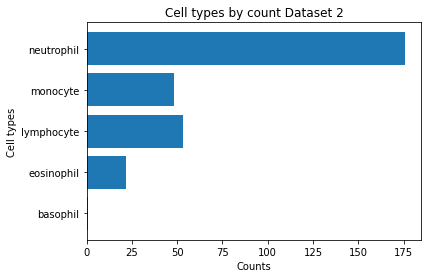

In [26]:
show_barplot_celltypes(df2, "Dataset 2")

('basophil', 3)
('eosinophil', 12)
('lymphocyte', 36)
('monocyte', 15)
('neutrophil', 33)


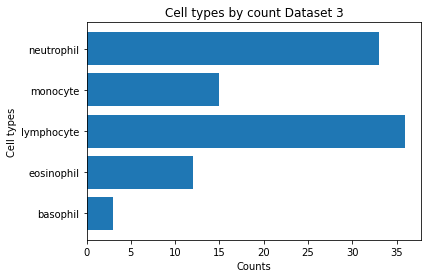

In [27]:
show_barplot_celltypes(df3, "Dataset 3")

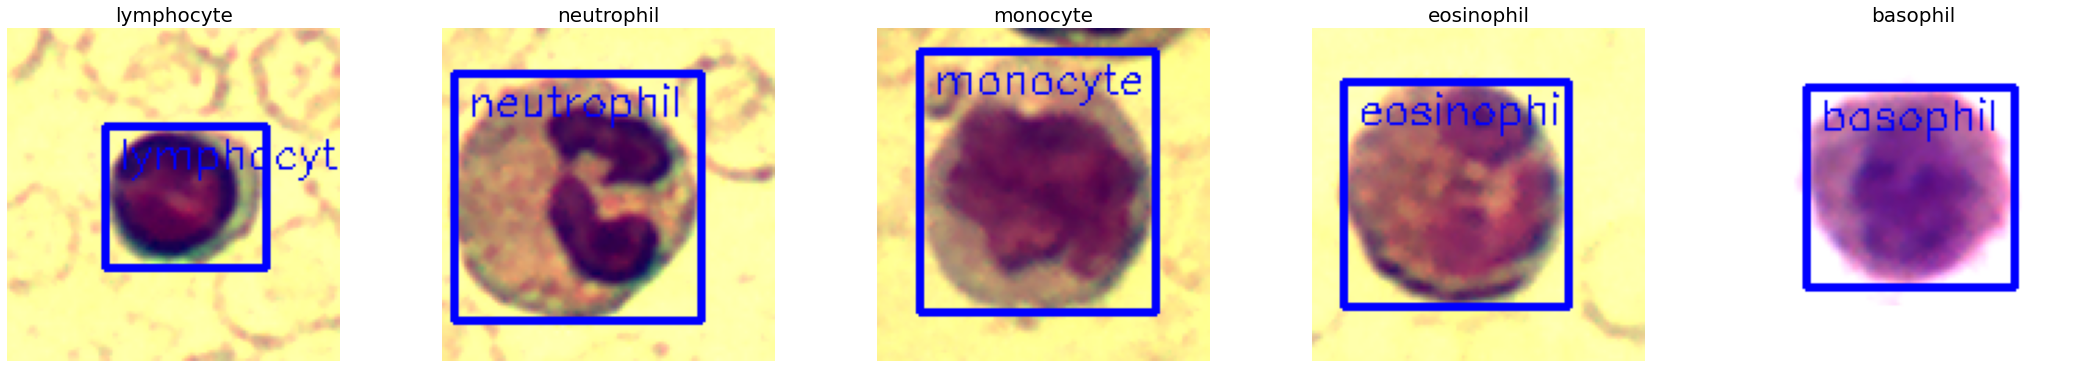

In [28]:
show_white_celltypes(df2)

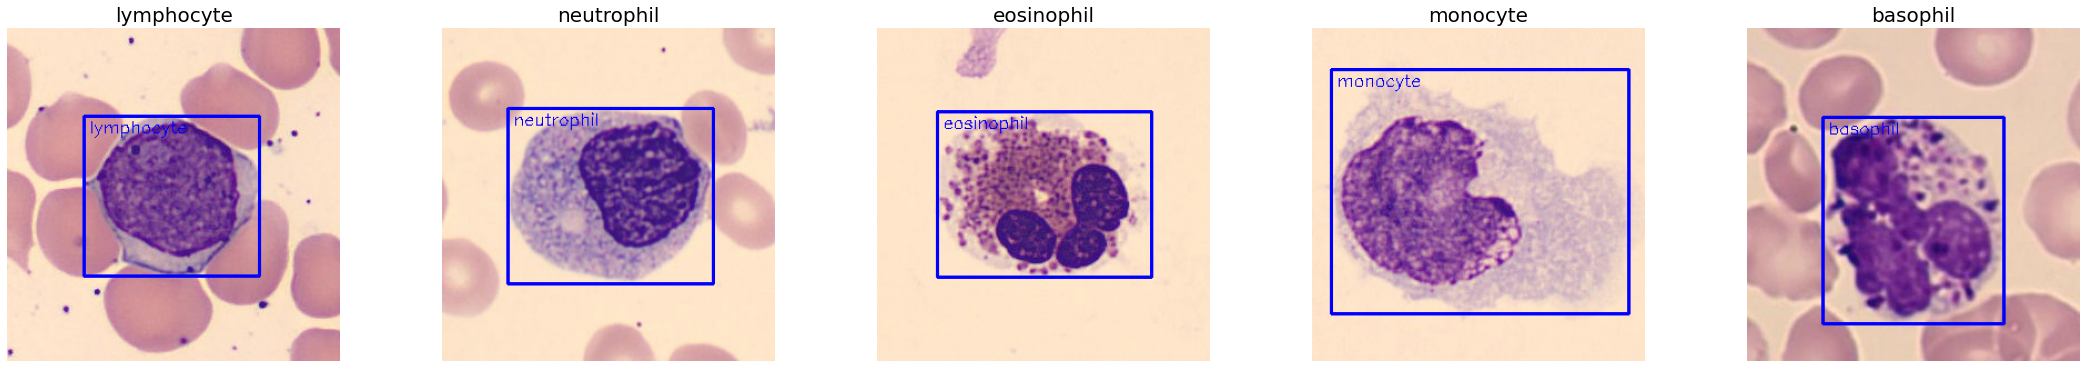

In [29]:
show_white_celltypes(df3)

### Dataset3 

Source: LISC database (http://users.cecs.anu.edu.au/~hrezatofighi/Data/Leukocyte%20Data.htm)

The dataset consists of images with masks again only for white blood cells:
- (720 x 567) BMP images (250)
- BMP masks with segmented white cell type

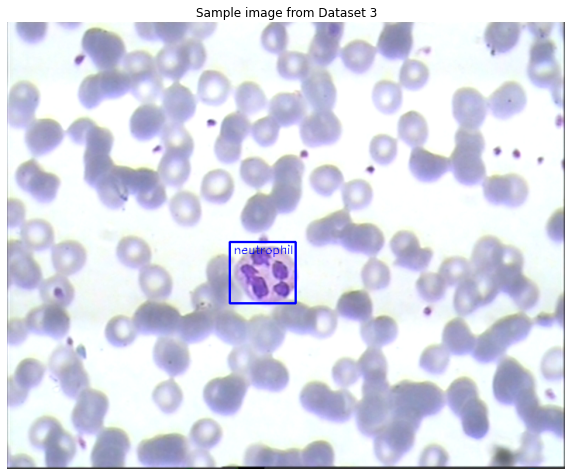

In [30]:
def show_sample_image_from_dataset3():    
    imagename = f"{str(1)}"
    celltype_dir = "neut"
    image = read_image(os.path.join(ds3_images_dir, celltype_dir, f"{imagename}.bmp"))
    mask = read_image(os.path.join(ds3_masks_dir, celltype_dir, ds3_masks_subdirname, f"{imagename}_expert.bmp"))
    label = "neutrophil"
    bb = get_bounding_box_from_mask(mask, label, imagename)

    show_image_with_bounding_boxes(image, f"Sample image from Dataset 3", [bb])
show_sample_image_from_dataset3()

In [31]:
def get_images_data_from_masks_in_separate_dir(images_dir, masks_dir, masks_subdirname, database_name):
    data = []

    celltypes_subfolders = ["Baso", "eosi", "lymp", "mono", "neut"]
    labels = {"neut": "neutrophil",
          "lymp": "lymphocyte",
          "mono": "monocyte",
          "eosi": "eosinophil",
          "Baso": "basophil"}

    for celltype_dir in os.listdir(images_dir):
        
        if celltype_dir in labels:
            if celltype_dir in labels:
                label = labels[celltype_dir]

                celltype_image_dir = os.path.join(images_dir, celltype_dir)
                count_files = len(os.listdir(celltype_image_dir)) 
                for i in range(0, count_files+1):

                    image_filename = f"{str(i+1)}"
                    image_filepath = os.path.join(celltype_image_dir, f"{image_filename}.bmp")
                    mask_filepath = os.path.join(masks_dir, celltype_dir, masks_subdirname, f"{image_filename}_expert.bmp")
                    image = read_image(image_filepath)
                    mask = read_image(mask_filepath)

                    if (image.any() and mask.any()):
                        bb = get_bounding_box_from_mask(mask, label, mask_filepath)
                        
                        if bb is not None:
                            data.append([image_filepath, mask_filepath, database_name, label, bb.xmin, bb.ymin, bb.xmax, bb.ymax])

    images_data = pd.DataFrame(data, columns=dataset_columns)
    return images_data


In [32]:
df4 = get_images_data_from_masks_in_separate_dir(ds3_images_dir, ds3_masks_dir, ds3_masks_subdirname, "Dataset4")
df4


Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset3/Ground Truth Segmentation/neut/areaforexpert1/31_expert.bmp'
Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset3/Ground Truth Segmentation/neut/areaforexpert1/38_expert.bmp'
Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset3/Ground Truth Segmentation/neut/areaforexpert1/42_expert.bmp'
Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset3/Ground Truth Segmentation/neut/areaforexpert1/47_expert.bmp'
Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset3/Ground Truth Segmentation/lymp/areaforexpert1/3_expert.bmp'
Not exactly one mask extracted from: 'drive/My Drive/Colab Notebooks/working/datasets/Dataset3/Ground Truth Segmentation/lymp/areaforexpert1/20_expert.bmp'
Not exactly one mask extracted from: 'drive/My Drive/Colab Notebo

image_filepath  ... ymax
0    drive/My Drive/Colab Notebooks/working/dataset...  ...  362
1    drive/My Drive/Colab Notebooks/working/dataset...  ...  345
2    drive/My Drive/Colab Notebooks/working/dataset...  ...  258
3    drive/My Drive/Colab Notebooks/working/dataset...  ...  310
4    drive/My Drive/Colab Notebooks/working/dataset...  ...  352
..                                                 ...  ...  ...
224  drive/My Drive/Colab Notebooks/working/dataset...  ...  562
225  drive/My Drive/Colab Notebooks/working/dataset...  ...  433
226  drive/My Drive/Colab Notebooks/working/dataset...  ...  347
227  drive/My Drive/Colab Notebooks/working/dataset...  ...  304
228  drive/My Drive/Colab Notebooks/working/dataset...  ...  386

[229 rows x 8 columns]

In [33]:
print("Unique files:", len(np.unique(df4.image_filepath)))

Unique files: 229


('basophil', 51)
('eosinophil', 39)
('lymphocyte', 45)
('monocyte', 48)
('neutrophil', 46)


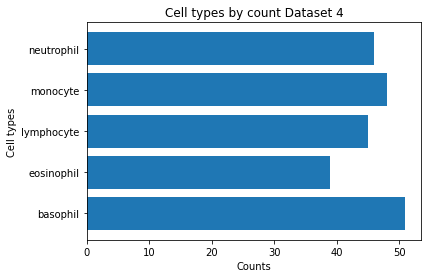

In [34]:
show_barplot_celltypes(df4, "Dataset 4")

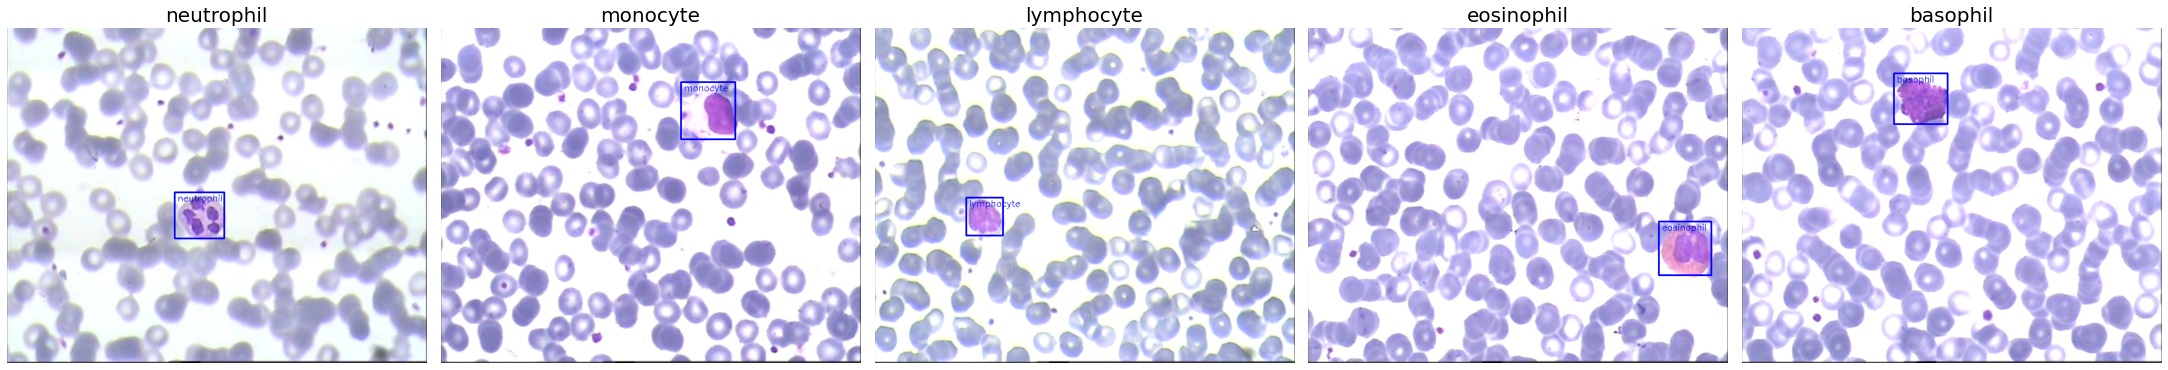

In [35]:
show_white_celltypes(df4)

## Conclusion

As we can see apart from the many rbcs from Dataset1, we do not have a lot of sample for the white cells and there are not very equally distributed.
We should keep that in mind and try to cope with it during the modeling part, for example using some data augmentation techniques.

In [36]:
df = pd.concat([df1, df2, df3, df4]).reset_index(drop=True)
df

image_filepath  ... ymax
0     drive/My Drive/Colab Notebooks/working/dataset...  ...  376
1     drive/My Drive/Colab Notebooks/working/dataset...  ...  435
2     drive/My Drive/Colab Notebooks/working/dataset...  ...  336
3     drive/My Drive/Colab Notebooks/working/dataset...  ...  461
4     drive/My Drive/Colab Notebooks/working/dataset...  ...  445
...                                                 ...  ...  ...
5509  drive/My Drive/Colab Notebooks/working/dataset...  ...  562
5510  drive/My Drive/Colab Notebooks/working/dataset...  ...  433
5511  drive/My Drive/Colab Notebooks/working/dataset...  ...  347
5512  drive/My Drive/Colab Notebooks/working/dataset...  ...  304
5513  drive/My Drive/Colab Notebooks/working/dataset...  ...  386

[5514 rows x 8 columns]

In [37]:
print("Unique files:", len(np.unique(df.image_filepath)))

Unique files: 992


The count of all WBCs: 998
('basophil', 58)
('eosinophil', 163)
('lymphocyte', 172)
('monocyte', 133)
('neutrophil', 472)


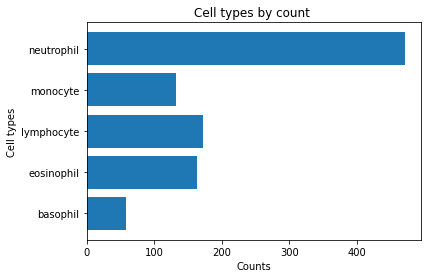

In [38]:
wbcs = df[((df.label != "rbc") & (df.label != "platelets"))]
print(f"The count of all WBCs: {len(wbcs)}")
show_barplot_celltypes(wbcs)

In [39]:
df.sample(len(df))

image_filepath  ... ymax
4602  drive/My Drive/Colab Notebooks/working/dataset...  ...  157
5363  drive/My Drive/Colab Notebooks/working/dataset...  ...  289
742   drive/My Drive/Colab Notebooks/working/dataset...  ...   61
63    drive/My Drive/Colab Notebooks/working/dataset...  ...  317
2610  drive/My Drive/Colab Notebooks/working/dataset...  ...  473
...                                                 ...  ...  ...
671   drive/My Drive/Colab Notebooks/working/dataset...  ...  180
5261  drive/My Drive/Colab Notebooks/working/dataset...  ...  228
2043  drive/My Drive/Colab Notebooks/working/dataset...  ...  245
55    drive/My Drive/Colab Notebooks/working/dataset...  ...  226
3518  drive/My Drive/Colab Notebooks/working/dataset...  ...  458

[5514 rows x 8 columns]

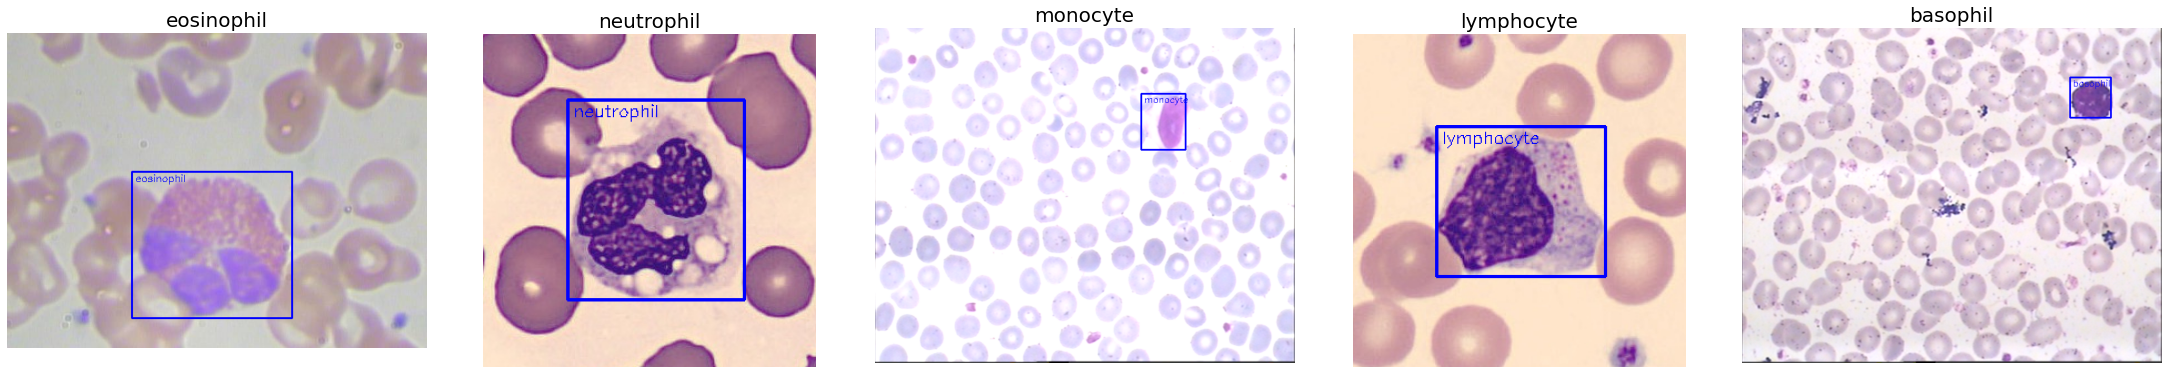

In [40]:
df_sample = df.sample(len(df)).reset_index(drop=True)
show_white_celltypes(df_sample)

Finally we can create a new CSV file with the extracted data from all the different datasets and use it in the actual modelling.

In [41]:
df.to_csv(os.path.join(datasets_dir, "cells.csv"), index=False)

So, let's continue with the more interesting part - the actual modelling and classifying the data!

## REMARKS

During the preprocessing and tests with a simple CNN, a problem with the BMP files of Dataset4 has occurred. A simple way (maybe more of a hack) to resolve it is to rewrite all the images from the dataset using OpenCV, as OpenCV correct this issue.

The error below appears when we call tf.image.decode_bmp(image_file) is called

> InvalidArgumentError: Input size should match (header_size + row_size *  abs_height) but they differ by 4 [Op:DecodeImage]

* It is not great that we do not save the original data locally but actually it is a public dataset and it is available from the provided link above.


In [55]:
def rewrite_image(image_filepath):
    im = read_image(image_filepath)
    cv2.imwrite(image_filepath, im)

In [56]:
reloaded_ds = pd.read_csv(os.path.join(datasets_dir, "cells.csv"))

In [57]:
for ds4_image_filepath in reloaded_ds.image_filepath[reloaded_ds.dataset == "Dataset4"].values:
    rewrite_image(ds4_image_filepath)